<a href="https://colab.research.google.com/github/deisof/BV2021/blob/main/main_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import pandas as pd
import numpy as np
import collections

In [38]:
submissions_train = pd.read_csv("submissions.csv", delimiter=';')

In [39]:
drop_cols = ['attempt_time']
if isinstance(drop_cols, str) or (not isinstance(drop_cols, collections.Iterable)):
        drop_cols = [drop_cols]
drop_col_names = np.intersect1d(submissions_train.columns, drop_cols)
submissions_train.drop(drop_col_names, axis=1, inplace=True)

In [40]:
submissions_train['date'] = pd.to_datetime(submissions_train.submission_time, unit='s')
submissions_train['day'] = submissions_train.date.dt.date

In [41]:
n_day = 1
users_min_time = submissions_train.groupby('user_id', as_index=False).agg({'submission_time': 'min'}).rename(
        {'submission_time': 'min_timestamp'}, axis=1)
users_min_time['min_timestamp'] += 60 * 60 * 24 * n_day
submission_data_d = pd.merge(submissions_train, users_min_time, how='inner', on='user_id')
cond = submission_data_d['submission_time'] <= submission_data_d['min_timestamp']
submission_data_d = submission_data_d[cond]
submissions = submission_data_d

In [42]:
# таблица с данными по каждому пользователю
users_data = submissions.groupby('user_id', as_index=False).agg({'submission_time': 'max'}).rename(columns={'submission_time': 'last_timestamp'})
# попытки сдачи практики пользователя
users_scores = submissions.pivot_table(index='user_id',
                                           columns='status',
                                           values='step_id',
                                           aggfunc='count',
                                           fill_value=0).reset_index()
users_data = users_data.merge(users_scores, on='user_id', how='outer')
users_data = users_data.fillna(0)
# колво дней на курсе
users_days = submissions.groupby('user_id').day.nunique().to_frame().reset_index()
users_data = users_data.merge(users_days, how='outer')

In [43]:
sertificate = pd.read_csv(f"sertificate.csv", delimiter=';')
sertificate['certificate_url'] = pd.isna(sertificate['certificate_url'])
users_data = users_data.merge(sertificate, on='user_id', how='outer')
users_data = users_data[:834]
users_data['certificate_url'] = users_data.certificate_url.fillna(False)
users_data['certificate_url'] = users_data['certificate_url'].astype('int32')

In [44]:
cheating = pd.read_csv("cheating_prohib.csv", delimiter=';')
all_cheating = (cheating.groupby('user_id', as_index=False)['cheating_probability (%)']
                .agg({'cheating_probability (%)': lambda a: sum(a)//len(a)})
                .rename(columns={'step_id': cheating}))

In [45]:
users_data = users_data.merge(all_cheating, on='user_id', how='outer')
users_data = users_data.rename(columns={'cheating_probability (%)': 'cheating'})
users_data['cheating'] = users_data.cheating.fillna(0)

In [46]:
comments = pd.read_csv(f"comments.csv", delimiter=';')

In [47]:
comments['date'] = pd.to_datetime(comments.time_utc, unit='s')
comments['day'] = comments.date.dt.date

In [48]:
n_day = 1
users_min_time = comments.groupby('user_id', as_index=False).agg({'time_utc': 'min'}).rename(
        {'time_utc': 'min_timestamp'}, axis=1)
users_min_time['min_timestamp'] += 60 * 60 * 24 * n_day
comments_data_d = pd.merge(comments, users_min_time, how='inner', on='user_id')
cond = comments_data_d['time_utc'] <= comments_data_d['min_timestamp']
comments_data_dsubmission_data_d = comments_data_d[cond]
all_comments = comments_data_d

In [49]:
all_comments = all_comments.drop(['step_id', 'time_utc', 'date', 'day', 'min_timestamp'], axis=1)

In [50]:
answer_comments = (all_comments.groupby('user_id', as_index=False)['comment_id']
                .agg({'comments': lambda a: len(a)}))

In [51]:
users_data = users_data.merge(answer_comments, on='user_id', how='outer')

In [52]:
users_data['comments'] = users_data.comments.fillna(0)

In [53]:
users_data = users_data[:834]

In [54]:
X = users_data.drop(['user_id', 'certificate_url'], axis=1)
y = users_data['certificate_url']

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import joblib

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

In [57]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=2, 
                            min_samples_leaf=10, min_samples_split=10, 
                            class_weight='balanced', max_depth=5)

rf.fit(X_train, y_train)
pred_proba = rf.predict_proba(X_test)
roc_score = roc_auc_score(y_test, pred_proba[:, 1])
print('roc на test', roc_score)

roc на test 0.7889016018306637


In [58]:
# важность фич
fimp = pd.DataFrame([rf.feature_importances_], columns=X_train.columns).T
fimp.columns = ['weight']
fimp.sort_values('weight', ascending=False)
fimp.head(15)

weight
last_timestamp  0.141515
correct         0.430812
wrong           0.176269
day             0.048344
cheating        0.162281
comments        0.040779

In [61]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor()
cat.fit(X_train,y_train,verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [62]:
from catboost import Pool, cv
params = {"iterations": 100,
          "depth": 2,
          "loss_function": "RMSE",
          "verbose": False}
cv_dataset = Pool(data=X_train,
                  label=y_train)
scores = cv(cv_dataset,
            params,
            fold_count=2, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

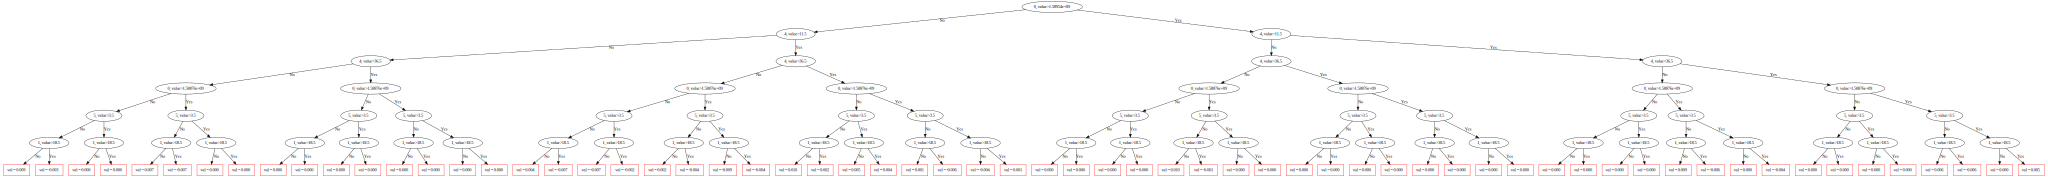

In [63]:
cat.plot_tree(tree_idx=0)

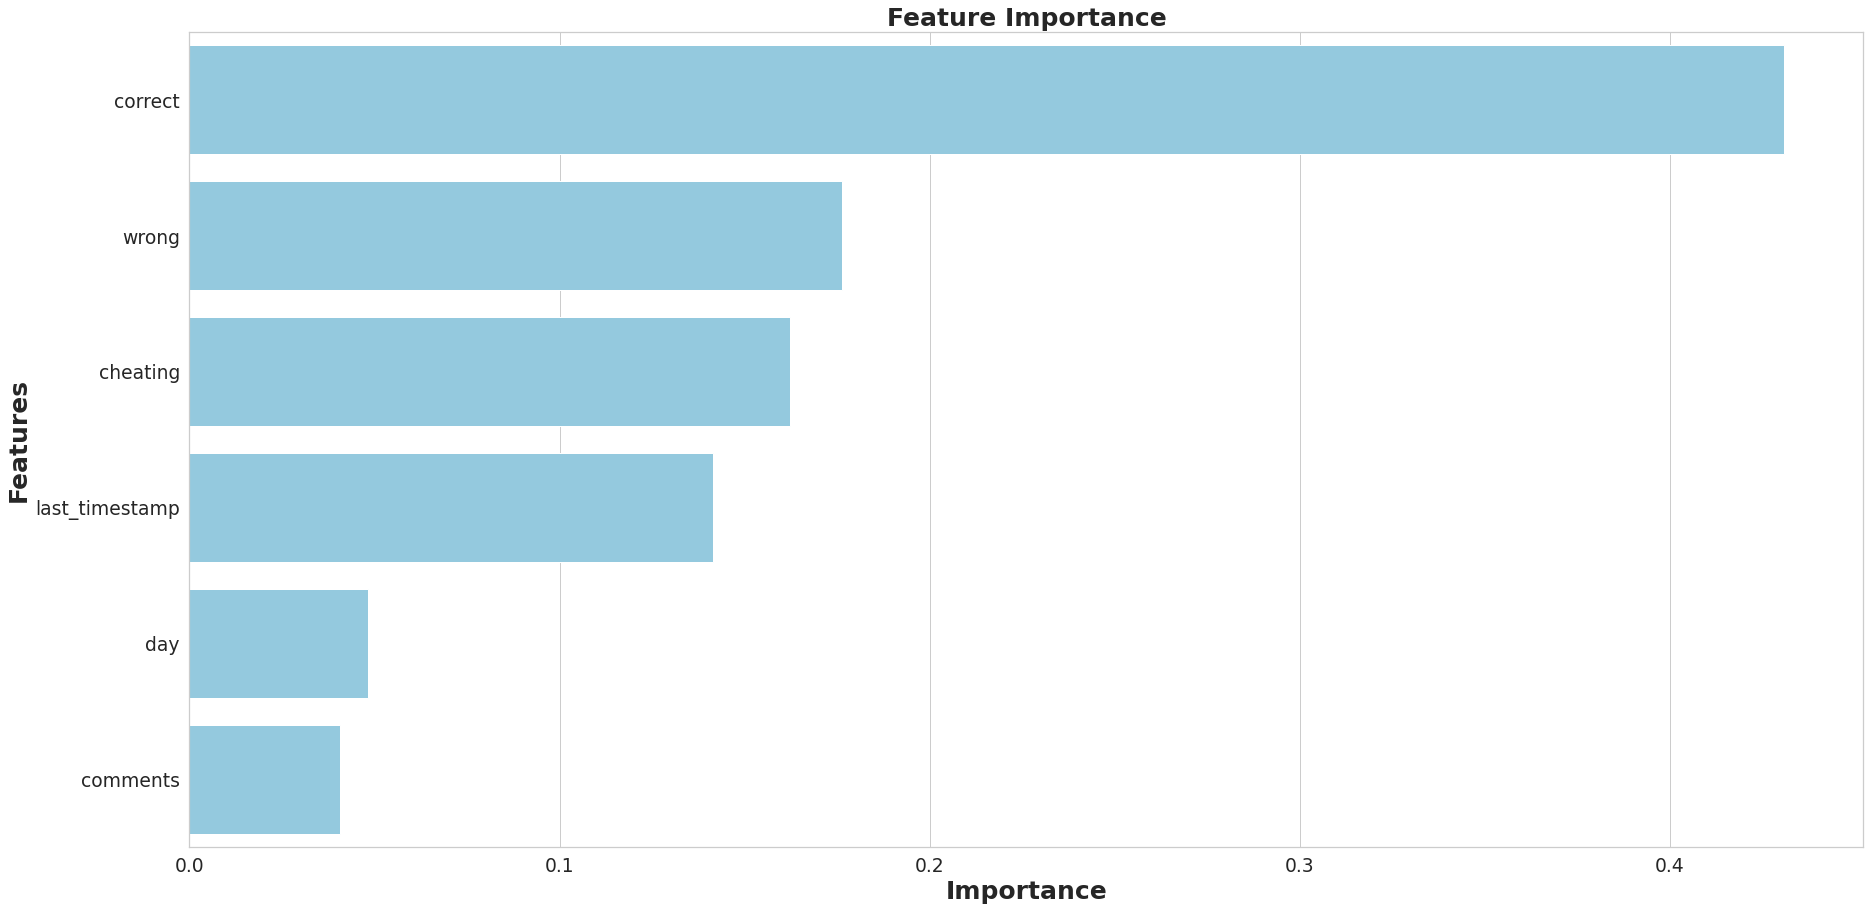

None

Features  Gini-Importance
0         correct         0.430812
1           wrong         0.176269
2        cheating         0.162281
3  last_timestamp         0.141515
4             day         0.048344
5        comments         0.040779

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
feats = {}
for feature, importance in zip(X_train.columns, rf.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegressionCV
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from catboost import CatBoostClassifier

In [66]:
rs = 42
clf = LogisticRegression(random_state=rs)
clf2 = RandomForestClassifier(random_state=rs, n_jobs =-1)
clf3 = SGDClassifier()
clf4 = SVC(random_state =rs)
clf5 = DecisionTreeClassifier(random_state=rs)
clf6 = SVC(class_weight="balanced", random_state =rs)
clf7 = DecisionTreeClassifier()
clf8 = ExtraTreeClassifier()
clf10 = LogisticRegressionCV() 
clf11 = CatBoostClassifier()

In [67]:
clflist = [clf, clf2, clf3, clf4, clf5, clf6, clf7, clf8, clf10, clf11]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Precision:   0.27
Recall:   0.50
F1-measure:   0.35
Accuracy:   0.55
              precision    recall  f1-score   support

         0.0       0.55      1.00      0.71        46
         1.0       0.00      0.00      0.00        38

    accuracy                           0.55        84
   macro avg       0.27      0.50      0.35        84
weighted avg       0.30      0.55      0.39        84



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


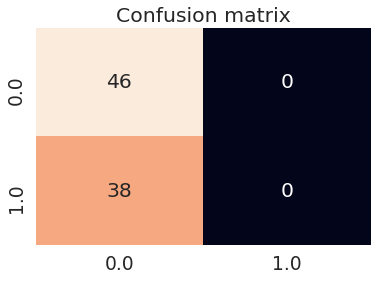

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Precision:   0.71
Recall:   0.71
F1-measure:   0.71
Accuracy:   0.71
              precision    recall  f1-score   support

         0.0       0.73      0.76      0.74        46
         1.0       0.69      0.66      0.68        38

    accuracy                           0.71        84
   macro avg       0.71      0.71      0.71        84
weighted avg       0.71      0.71      0.71        84



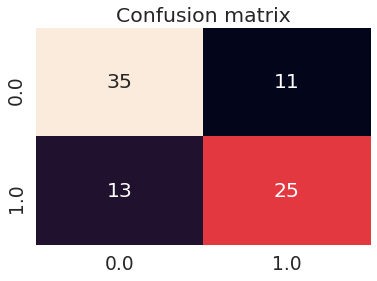

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Precision:   0.23
Recall:   0.50
F1-measure:   0.31
Accuracy:   0.45
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        46
         1.0       0.45      1.00      0.62        38

    accuracy                           0.45        84
   macro avg       0.23      0.50      0.31        84
weighted avg       0.20      0.45      0.28        84



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


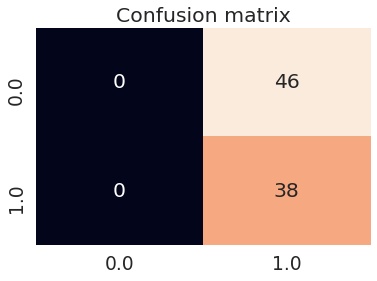

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)
Precision:   0.27
Recall:   0.50
F1-measure:   0.35
Accuracy:   0.55
              precision    recall  f1-score   support

         0.0       0.55      1.00      0.71        46
         1.0       0.00      0.00      0.00        38

    accuracy                           0.55        84
   macro avg       0.27      0.50      0.35        84
weighted avg       0.30      0.55      0.39        84



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


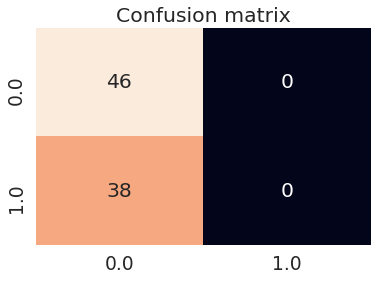

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')
Precision:   0.65
Recall:   0.64
F1-measure:   0.64
Accuracy:   0.65
              precision    recall  f1-score   support

         0.0       0.66      0.76      0.71        46
         1.0       0.65      0.53      0.58        38

    accuracy                           0.65        84
   macro avg       0.65      0.64      0.64        84
weighted avg       0.65      0.65      0.65        84



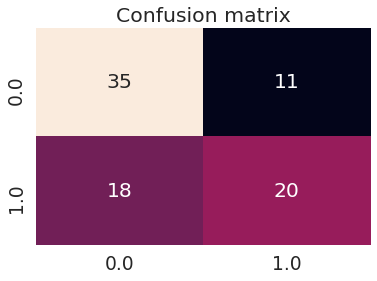

SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)
Precision:   0.57
Recall:   0.54
F1-measure:   0.50
Accuracy:   0.57
              precision    recall  f1-score   support

         0.0       0.57      0.87      0.69        46
         1.0       0.57      0.21      0.31        38

    accuracy                           0.57        84
   macro avg       0.57      0.54      0.50        84
weighted avg       0.57      0.57      0.52        84



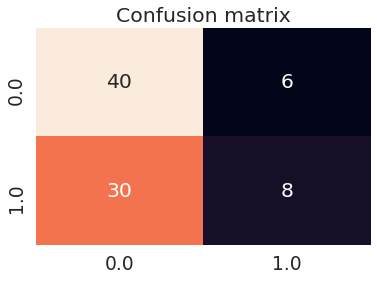

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Precision:   0.60
Recall:   0.60
F1-measure:   0.60
Accuracy:   0.61
              precision    recall  f1-score   support

         0.0       0.63      0.70      0.66        46
         1.0       0.58      0.50      0.54        38

    accuracy                           0.61        84
   macro avg       0.60      0.60      0.60        84
weighted avg       0.60      0.61      0.60        84



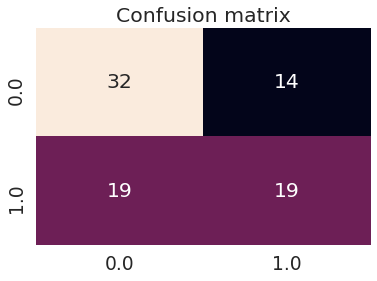

ExtraTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, random_state=None,
                    splitter='random')
Precision:   0.66
Recall:   0.66
F1-measure:   0.66
Accuracy:   0.67
              precision    recall  f1-score   support

         0.0       0.70      0.70      0.70        46
         1.0       0.63      0.63      0.63        38

    accuracy                           0.67        84
   macro avg       0.66      0.66      0.66        84
weighted avg       0.67      0.67      0.67        84



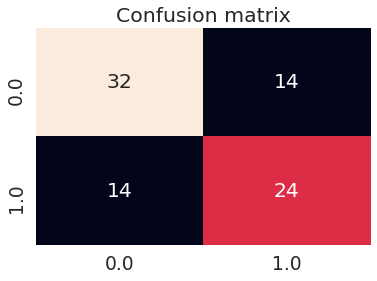

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)
Precision:   0.27
Recall:   0.50
F1-measure:   0.35
Accuracy:   0.55
              precision    recall  f1-score   support

         0.0       0.55      1.00      0.71        46
         1.0       0.00      0.00      0.00        38

    accuracy                           0.55        84
   macro avg       0.27      0.50      0.35        84
weighted avg       0.30      0.55      0.39        84



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


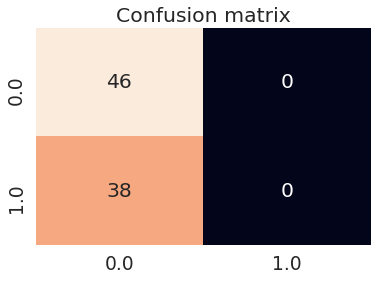

Learning rate set to 0.009111
0:	learn: 0.6914891	total: 5.76ms	remaining: 5.75s
1:	learn: 0.6896651	total: 8.69ms	remaining: 4.33s
2:	learn: 0.6882040	total: 9.95ms	remaining: 3.31s
3:	learn: 0.6861675	total: 11.2ms	remaining: 2.79s
4:	learn: 0.6846045	total: 12.5ms	remaining: 2.49s
5:	learn: 0.6829786	total: 13.7ms	remaining: 2.28s
6:	learn: 0.6815424	total: 15ms	remaining: 2.13s
7:	learn: 0.6795228	total: 16.2ms	remaining: 2.01s
8:	learn: 0.6781997	total: 17.2ms	remaining: 1.9s
9:	learn: 0.6769006	total: 18.5ms	remaining: 1.83s
10:	learn: 0.6756226	total: 19.3ms	remaining: 1.73s
11:	learn: 0.6742042	total: 20.5ms	remaining: 1.69s
12:	learn: 0.6726477	total: 21.7ms	remaining: 1.65s
13:	learn: 0.6708887	total: 22.9ms	remaining: 1.61s
14:	learn: 0.6694575	total: 24.2ms	remaining: 1.59s
15:	learn: 0.6680855	total: 25.2ms	remaining: 1.55s
16:	learn: 0.6669000	total: 26.4ms	remaining: 1.53s
17:	learn: 0.6651884	total: 27.7ms	remaining: 1.51s
18:	learn: 0.6636921	total: 28.9ms	remaining: 1

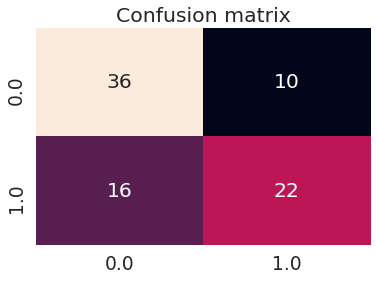

In [68]:
for classif in clflist:
    clf = classif
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    print(classif)
    print("Precision: {0:6.2f}".format(metrics.precision_score(y_test, predictions, average='macro')))
    print("Recall: {0:6.2f}".format(metrics.recall_score(y_test, predictions, average='macro')))
    print("F1-measure: {0:6.2f}".format(metrics.f1_score(y_test, predictions, average='macro')))
    print("Accuracy: {0:6.2f}".format(metrics.accuracy_score(y_test, predictions)))
    print(classification_report(y_test, predictions))
    labels = clf.classes_
    sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
    plt.title("Confusion matrix")
    plt.show()

In [69]:
estimator_limited = rf.estimators_[5]
estimator_nonlimited = rf.estimators_[5]

from sklearn.tree import export_graphviz
export_graphviz(estimator_limited, out_file='tree_limited.dot',
                rounded = True, proportion = False, precision = 2, filled = True)
                
export_graphviz(estimator_nonlimited, out_file='tree_nonlimited.dot',
                rounded = True, proportion = False, precision = 2, filled = True)
                
!dot -Tpng tree_limited.dot -o tree_limited.png -Gdpi=600

from IPython.display import Image
Image(filename = 'tree_limited.png')

!dot -Tpng tree_nonlimited.dot -o tree_nonlimited.png -Gdpi=600

Image(filename = 'tree_nonlimited.png')

In [81]:
cb = CatBoostClassifier(n_estimators=20, max_depth=10)

cb.fit(X_train, y_train)
pred_proba = cb.predict_proba(X_test)
roc_score = roc_auc_score(y_test, pred_proba[:, 1])
print('roc на test', roc_score)

Learning rate set to 0.329261
0:	learn: 0.6568019	total: 8.16ms	remaining: 155ms
1:	learn: 0.6326186	total: 16.3ms	remaining: 147ms
2:	learn: 0.6140215	total: 24ms	remaining: 136ms
3:	learn: 0.5937329	total: 32ms	remaining: 128ms
4:	learn: 0.5776490	total: 40.3ms	remaining: 121ms
5:	learn: 0.5643155	total: 48.1ms	remaining: 112ms
6:	learn: 0.5554711	total: 49.8ms	remaining: 92.4ms
7:	learn: 0.5476100	total: 53.9ms	remaining: 80.8ms
8:	learn: 0.5397002	total: 56.2ms	remaining: 68.7ms
9:	learn: 0.5302188	total: 63.7ms	remaining: 63.7ms
10:	learn: 0.5195592	total: 71.5ms	remaining: 58.5ms
11:	learn: 0.5127852	total: 79.5ms	remaining: 53ms
12:	learn: 0.5066865	total: 87.7ms	remaining: 47.2ms
13:	learn: 0.5062242	total: 88.6ms	remaining: 38ms
14:	learn: 0.5018073	total: 96.7ms	remaining: 32.2ms
15:	learn: 0.4967139	total: 105ms	remaining: 26.2ms
16:	learn: 0.4877686	total: 113ms	remaining: 19.9ms
17:	learn: 0.4862067	total: 114ms	remaining: 12.6ms
18:	learn: 0.4820235	total: 116ms	remaining